In [415]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

# Analytically

In [416]:
np.random.seed(0)

In [417]:
mu1 = 0.1
mu2 = 0.2
sigma1 = 0.25
sigma2 = 0.5
rho = 0.5
t = 1

In [418]:
def folded_normal(mu, sigma):
    sigma = np.sqrt(sigma)
    return mu * (1 - 2 * stats.norm.cdf(-mu / sigma)) \
        + sigma * np.sqrt(2 / math.pi) * np.exp(-mu ** 2 / (2 * sigma ** 2))

In [419]:
no_netting = folded_normal(mu1 / 2, (sigma1 ** 2) * (t / 4)) + folded_normal(mu2 / 2, (sigma2 ** 2) * (t / 4)) + (
            mu1 + mu2) / 2

In [420]:
netting = folded_normal(0.5 * (mu1 + mu2), (sigma1 ** 2 + sigma2 ** 2 + 2 * rho * sigma1 * sigma2) * (t / 4)) + (
            mu1 + mu2) / 2

In [421]:
print(round(no_netting,4), round(netting,4))

0.4728 0.4406


# Numerically

In [422]:
# generate random normal variables
nTrials =10_000_000
def generate_mtm(t):
    Z_1, Z_2 = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], nTrials).T
    Z_1 *= sigma1 * np.sqrt(t)
    Z_2 *= sigma2 * np.sqrt(t)
    X_1 = mu1 + Z_1
    X_2 = mu2 + Z_2
    # no netting
    one_step_no_netting = np.maximum(X_1, 0) + np.maximum(X_2, 0)
    # netting
    one_step_netting = np.maximum(X_1 + X_2, 0)
    return one_step_no_netting, one_step_netting

In [423]:
one_step_no_netting, one_step_netting = generate_mtm(1)

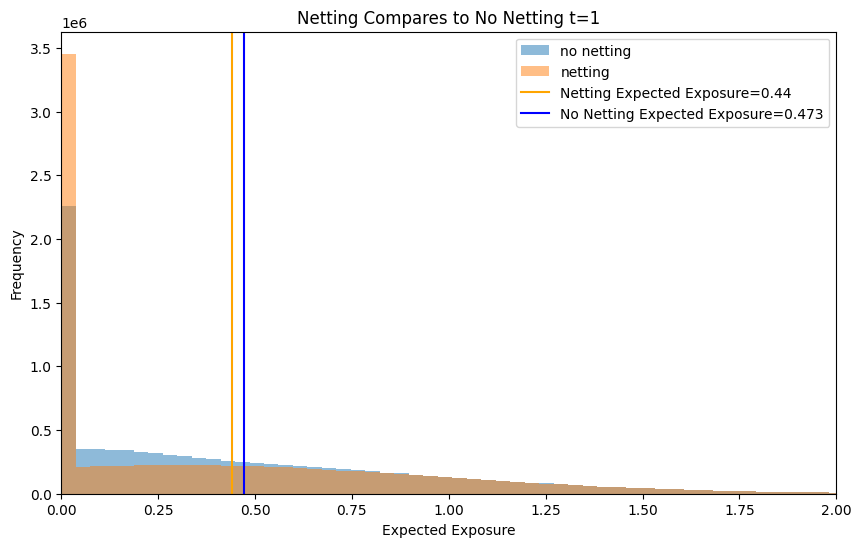

In [424]:
plt.figure(figsize=(10, 6))
plt.hist(one_step_no_netting, bins=100, alpha=0.5, label='no netting')
plt.hist(one_step_netting, bins=100, alpha=0.5, label='netting')
plt.axvline(x=np.mean(one_step_netting), color='orange',
            label=f'Netting Expected Exposure={round(np.mean(one_step_netting), 3)}')
plt.axvline(x=np.mean(one_step_no_netting), color='blue',
            label=f'No Netting Expected Exposure={round(np.mean(one_step_no_netting), 3)}')
plt.xlim(0, 2.0)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Expected Exposure')
plt.title('Netting Compares to No Netting t=1')
plt.show()

In [425]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [431]:
# # this takes forever to run
# pfe_no_netting=[]
# pfe_netting=[]
# for t in np.arange(0.1, 3, 0.1):
#     one_step_no_netting, one_step_netting = generate_mtm(t)
#     pfe_no_netting.append(np.mean(one_step_no_netting[one_step_no_netting>=np.percentile(one_step_no_netting, 90)]))
#     pfe_netting.append(np.mean(one_step_netting[one_step_netting>=np.percentile(one_step_netting, 90)]))

In [426]:
def pfe(t):
    one_step_no_netting, one_step_netting = generate_mtm(t)
    pfe_no_netting,pfe_netting=np.mean(one_step_no_netting[one_step_no_netting>=np.percentile(one_step_no_netting, 90)]), np.mean(one_step_netting[one_step_netting>=np.percentile(one_step_netting, 90)])
    return pfe_no_netting,pfe_netting

In [427]:
# Parallel computing
pfe_data = Parallel(n_jobs=8)(delayed(pfe)(t) for t in tqdm(np.arange(0.1, 20.1, 0.1)))

100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


In [428]:
pfe_data = np.array(pfe_data)

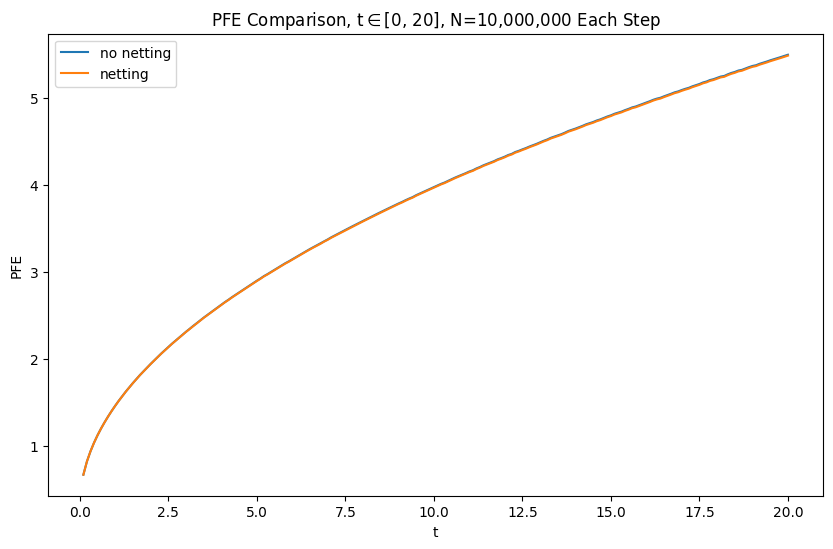

In [429]:
# plot PFE, with y axis in percentage
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.1, 20.1, 0.1), pfe_data[:, 0], label='no netting')
plt.plot(np.arange(0.1, 20.1, 0.1), pfe_data[:, 1], label='netting')
plt.legend()
plt.ylabel('PFE')
plt.xlabel('t')
plt.title(r'PFE Comparison, t$\in$[0, 20], N=10,000,000 Each Step')
plt.show()

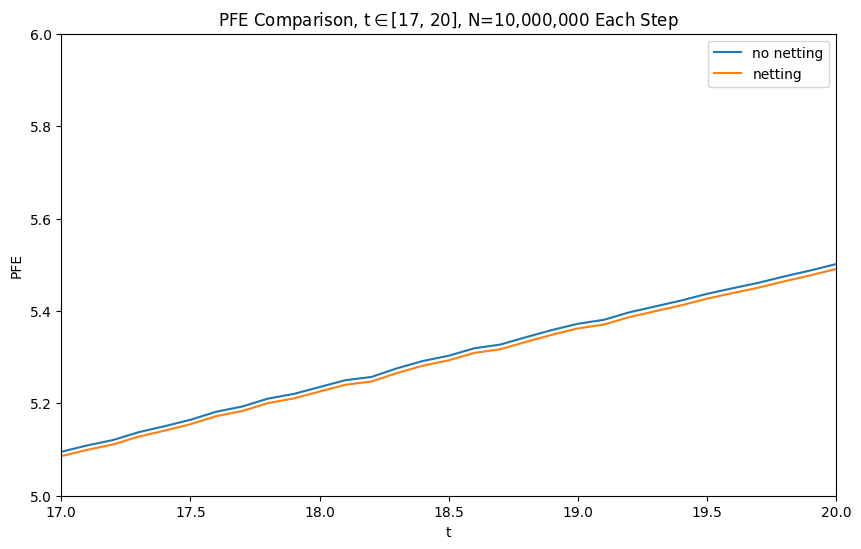

In [430]:
# plot PFE
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.1, 20.1, 0.1), pfe_data[:, 0], label='no netting')
plt.plot(np.arange(0.1, 20.1, 0.1), pfe_data[:, 1], label='netting')
plt.legend()
plt.xlim(17, 20)
plt.ylim(5,6)
plt.ylabel('PFE')
plt.xlabel('t')
plt.title(r'PFE Comparison, t$\in$[17, 20], N=10,000,000 Each Step')
plt.show()